## Ridge Regression (linear regression with L2 regularisation)

### Task I: Derivation of weight update steps of Stocastic Gradient Descent (SGD) and Batch Gradient Descent (BGD) for Linear Regression with L2 Regularization


### Importing Libraries

In [4]:
options(warn=-1) #to stop the warnings
library(ggplot2) # for plotting functions.
library(reshape2) # for melt and cast functions

### Assigning values to variables used globally 

In [5]:

# Set initial values for learning rate, termination thershold and lambda 
epsilon = .001
eta = .01
lambda = 0.02
max_epoch = 18

In [6]:
# reading the data
read_data <- function(fname, sc) {
   data <- read.csv(file=fname,head=TRUE,sep=",")
   nr = dim(data)[1]
   nc = dim(data)[2]
   x = data[1:nr,1:(nc-1)]
   y = data[1:nr,nc]
   if (isTRUE(sc)) {
      x = scale(x)
      y = scale(y)
   }
   return (list("x" = x, "y" = y))
}

dtrain = read_data("Task1C_train.csv", TRUE)
dtest = read_data("Task1C_test.csv", TRUE)

In [7]:
# auxiliary function to calculate labels based on the estimated coefficients
predict_func <- function(Phi, w){
    return(Phi%*%w) ## Calculate matrix product.
} 

# auxiliary function to calculate the objective function for the training
train_obj_func <- function (Phi, w, label, lambda){
    # the L2 regulariser is included in the objective function for training 
    return(mean((predict_func(Phi, w) - label)^2) + .5 * lambda * w %*% w)
}

# auxiliary function to compute the error of the model
get_errors <- function(train_data, test_data, W) {
   n_weights = dim(W)[1]
   errors = matrix(,nrow=n_weights, ncol=2)
   for (tau in 1:n_weights) {
      errors[tau,1] = train_obj_func(train_data$x, W[tau,],train_data$y, lambda) # tracks training error
      errors[tau,2] = train_obj_func(test_data$x, W[tau,],test_data$y, lambda) # tracks testing error
   }
   return(errors)
}

## Task II: Implementation of SGD and BGD algorithms in R


#### Updating the SGD weight vector

In [8]:
sgd_update_weight <- function(W_prev, x, y_true, y_pred, lambda, eta) {
   # L2 REG penalty term lambda * W_prev is added to grad
   grad = - (y_true-y_pred) * x + (lambda * W_prev)
   return(W_prev - eta * grad)
}

#### Updating the BGD weight vector

In [9]:
bgd_update_weight <- function(W_prev, x, y_true, y_pred, lambda, eta) {
   # MODIFY THIS FUNCTION FOr L2 REG
   grad = -colMeans(matrix((y_true-y_pred),nrow=dim(x)[1],ncol=dim(x)[2]) * x) + (lambda * W_prev)
   return (W_prev - eta * grad)
}

#### Implementation of Stocastic Gradient Descent (SGD) for Linear Regression with L2 Regularization

In [10]:
sgd_train <- function(train_x, train_y, lambda, eta, epsilon, max_epoch) {

   train_len = dim(train_x)[1]
   tau_max = max_epoch * train_len # Maximum number of iterations

   W <- matrix(,nrow=tau_max, ncol=ncol(train_x)) # empty matrix to store weight vector
   W[1,] <- runif(ncol(train_x))
  
   tau = 1 # counter 
   obj_func_val <-matrix(,nrow=tau_max, ncol=1) 
   obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)

   while (tau <= tau_max){

       # check termination criteria
       if (obj_func_val[tau,1]<=epsilon) {break}
 
       # shuffle data:
       train_index <- sample(1:train_len, train_len, replace = FALSE)
    
       # loop over each datapoint
       for (i in train_index) {
           # increment the counter
           tau <- tau + 1
           if (tau > tau_max) {break}

           # make the weight update
           y_pred <- predict_func(train_x[i,], W[tau-1,])
           W[tau,] <- sgd_update_weight(W[tau-1,], train_x[i,], train_y[i], y_pred, lambda, eta)

           # keep track of the objective funtion
           obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)
       }
   }
   # resulting values for the training objective function as well as the weights
   return(list('vals'=obj_func_val,'W'=W))
}

#### Implementation of Batch Gradient Descent (BGD) for Linear Regression with L2 Regularization

In [11]:
bgd_train <- function(train_x, train_y, lambda, eta, epsilon, max_epoch) {

   train_len = dim(train_x)[1]

   W <- matrix(,nrow=(max_epoch+1), ncol=ncol(train_x))
   W[1,] <- runif(ncol(train_x))

   tau = 1 # counter 
   obj_func_val <-matrix(,nrow=(max_epoch+1), ncol=1)
   obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)

   trainin_size = dim(train_x)[1]
   for (tau in 1:max_epoch){

       # check termination criteria
       if (obj_func_val[tau,1]<=epsilon) {break}

       # make prediction over the training set
       y_pred = train_x %*% W[tau,]

       # update the weight you may decide to chose linea search or not (we are not using line search here)
       W[tau+1,] = bgd_update_weight(W[tau,], train_x, train_y, y_pred, lambda, eta)

       # keep track of the objective funtion
       obj_func_val[tau+1,1] = train_obj_func(train_x, W[tau+1,],train_y, lambda)
   } 
   # resulting values for the training objective function as well as the weights
   return(list('vals'=obj_func_val,'W'=W))
}

## Task III: Compare SGD and BGD implementations

#### Run SGD and BGD

In [12]:
sgd_train_res = sgd_train(dtrain$x, dtrain$y, lambda, eta, epsilon, max_epoch) # Initialize and run SGD
sgd_errors = get_errors(dtrain, dtest, sgd_train_res$W)

bgd_train_res = bgd_train(dtrain$x, dtrain$y, lambda, eta, epsilon, max_epoch) # Initialize and run BGD
bgd_errors = get_errors(dtrain, dtest, bgd_train_res$W)

#### Plot of error rates for SGD and BGD

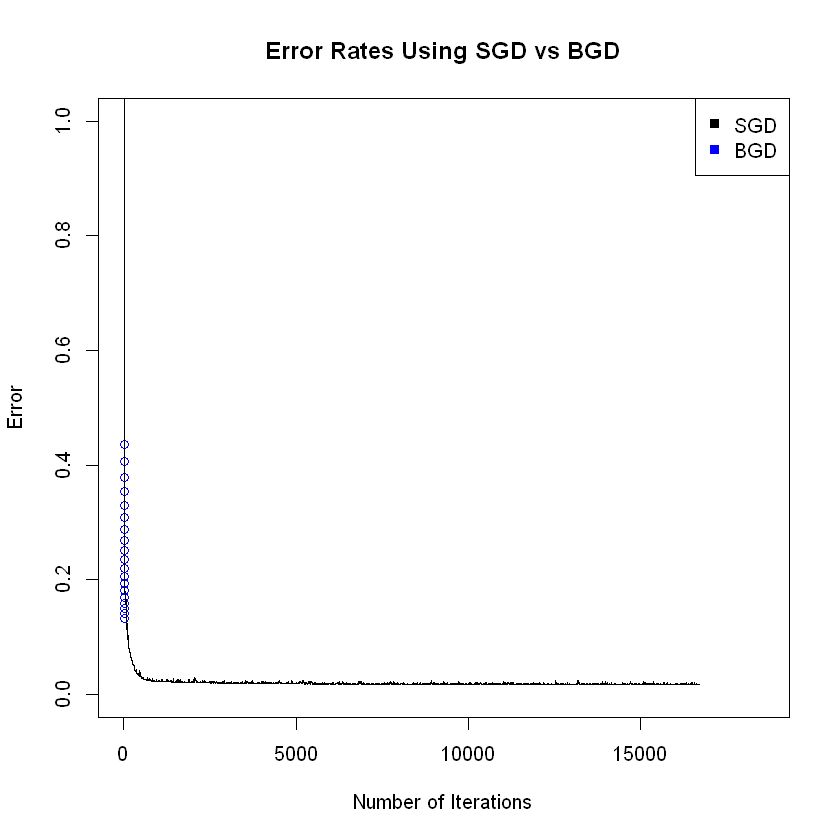

In [13]:
plot(bgd_errors[,1], type="p", col="blue",ylim=c(0,1), xlim=c(0,18600), xlab="Number of Iterations", ylab="Error",main="Error Rates Using SGD vs BGD")
lines(sgd_errors[,1], type="l", col="black")
legend("topright", legend = c("SGD", "BGD"), col = c(1, 4), pch = c(15, 15))